<a href="https://colab.research.google.com/github/mpipher2/SCS_3253_ML_NLP/blob/master/cannabis_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cannabis Dataset
## SCS_3253_Machine_Learning
Due: July 25, 2019 <br>
By: Taylor Van Valkenburg,  Kristen Celotto, Victor Hugo Mazariegos, and Mark Pipher


In [0]:
#imports
import os
import pandas as pd
import numpy as np
import string

# ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split

import gensim

# nlp libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('word_tokenize')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading word_tokenize: Package 'word_tokenize' not
[nltk_data]     found in index
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
#load the data
df1 = pd.read_csv('https://raw.githubusercontent.com/mpipher2/SCS_3253_ML_NLP/master/cannabis.csv')

### Part 1: Data Preparation and Exploratory Data Analysis

Basic overview of the data

In [0]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 6 columns):
Strain         2351 non-null object
Type           2351 non-null object
Rating         2351 non-null float64
Effects        2351 non-null object
Flavor         2305 non-null object
Description    2318 non-null object
dtypes: float64(1), object(5)
memory usage: 110.3+ KB


In [0]:
df1.describe()

,Rating
count,2351.000000
mean,4.310634
std,0.836394
min,0.000000
25%,4.200000
50%,4.400000
75%,4.700000
max,5.000000


 Looking at the attribute types we notice that all of the attributes are categorical and our target variable 'Rating' is a continuous number however the question we are trying to answer deals with our target variable being categorical so in later cells you will see we convert the only continuous value to be a categorical value.

In [0]:
## Looking at types and how the rating are distributed by each 
df1['Type'].value_counts()

hybrid    1212
indica     699
sativa     440
Name: Type, dtype: int64

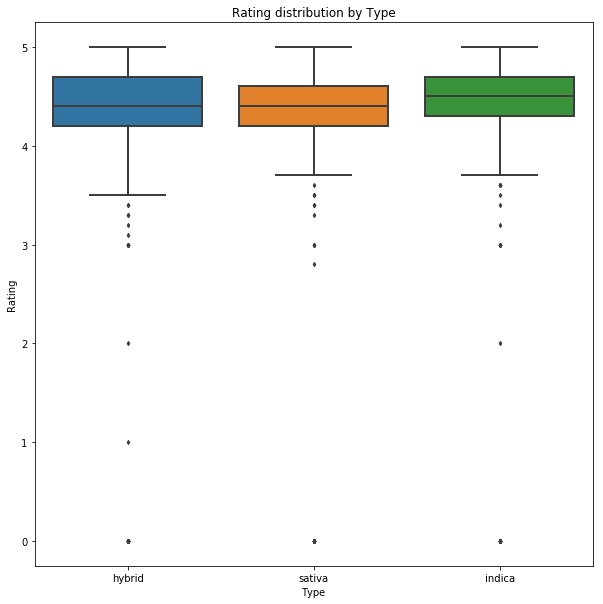

In [0]:
## Looking at the rating with respect to the types
%matplotlib inline
plt.figure(figsize=(10,10))
## set ax as axis
ax = sns.boxplot(x="Type",y='Rating', data=df1, fliersize=3, linewidth=2)
ax.set(xlabel="Type", ylabel="Rating", title="Rating distribution by Type")
plt.show()

As we can see just by the quick description majority of the ratings are above 4. Which means there is a right skew of our target variable Rating. We can also visualy see by the boxplot and the percentales that the rating are heavily in the higher ratings. However we are interest in helping companies decide what strains to stock so to better split the rating we sperate the rating into three categories that have an equal number of strains in each bin

<p>
    Preprocess the Decription, Effects and Flavor columns by turning them into arrarys of words
    Not required for the code below, but I've left it in just in case we need it in the future
</p>

In [0]:
#convert dtypes
str_cols = ['Effects',
            'Flavor',
            'Description']

for col in str_cols:
    df1[col] = df1[col].astype(str)

In [0]:
#drop rows with missing values
df1 = df1.loc[(df1['Effects'] != 'None') | (df1['Flavor'] != 'None') | (df1['Description'] != 'nan')]

In [0]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2351 entries, 0 to 2350
Data columns (total 6 columns):
Strain         2351 non-null object
Type           2351 non-null object
Rating         2351 non-null float64
Effects        2351 non-null object
Flavor         2351 non-null object
Description    2351 non-null object
dtypes: float64(1), object(5)
memory usage: 128.6+ KB


In [0]:
#create the arrays
df1['Effects'] = df1['Effects'].apply(lambda x: x[0:].split(','))
df1['Flavor'] = df1['Flavor'].apply(lambda x: x[0:].split(','))


In [0]:
#bin the target variable
bins = np.array([4.2, 4.7])

df1['Rating_bin'] = np.digitize(df1['Rating'], bins=bins)

1    1343
2     575
0     359
Name: Rating_bin, dtype: int64


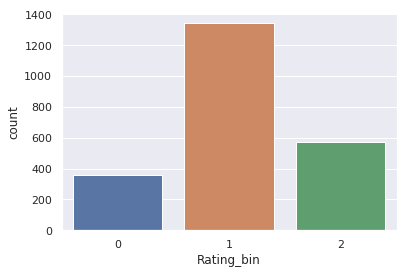

In [0]:
print(df1['Rating_bin'].value_counts())

sns.set(style="darkgrid")
ax = sns.countplot(x="Rating_bin", data=df1)

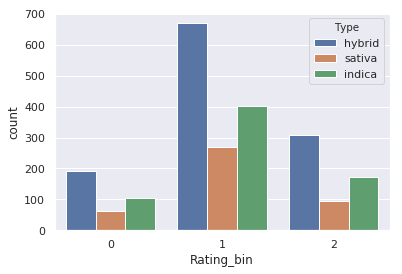

In [0]:
# Looking closer at how the types are divided within those counts
ax = sns.countplot(x="Rating_bin", hue="Type", data=df1)

From this visualization it clean to say that the marjoity of category 1 in rating_bin Hybrid has the largest bumber by far in that bin 

## Looking at the other attributes that include text.

In [0]:
df1.head(5)

,Strain,Type,Rating,Effects,Flavor,Description,Rating_bin
0,100-Og,hybrid,4.0,"[Creative, Energetic, Tingly, Euphoric, Relaxed]","[Earthy, Sweet, Citrus]",$100 OG is a 50/50 hybrid strain that packs a ...,0
1,98-White-Widow,hybrid,4.7,"[Relaxed, Aroused, Creative, Happy, Energetic]","[Flowery, Violet, Diesel]",The ‘98 Aloha White Widow is an especially pot...,2
2,1024,sativa,4.4,"[Uplifted, Happy, Relaxed, Energetic, Creative]","[Spicy/Herbal, Sage, Woody]",1024 is a sativa-dominant hybrid bred in Spain...,1
3,13-Dawgs,hybrid,4.2,"[Tingly, Creative, Hungry, Relaxed, Uplifted]","[Apricot, Citrus, Grapefruit]",13 Dawgs is a hybrid of G13 and Chemdawg genet...,1
4,24K-Gold,hybrid,4.6,"[Happy, Relaxed, Euphoric, Uplifted, Talkative]","[Citrus, Earthy, Orange]","Also known as Kosher Tangie, 24k Gold is a 60%...",1


### Visualizing the effect and flavor

In [0]:
## representing the different effects
# Exporing Effect by making a same dataframe to explore all the different effects and how they are related to the rating bins
effect_df = pd.get_dummies(pd.DataFrame(df1['Effects'].tolist()).stack()).sum(level=0)

In [0]:
effect_df['Type'] = df1['Type']
effect_df['Rating_bin'] = df1['Rating_bin']

In [0]:
effect_df.head()

,Aroused,Creative,Dry,Energetic,Euphoric,Focused,Giggly,Happy,Hungry,Mouth,None,Relaxed,Sleepy,Talkative,Tingly,Uplifted,Type,Rating_bin
0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,hybrid,0.0
1,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,hybrid,2.0
2,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,sativa,1.0
3,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,hybrid,1.0
4,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,hybrid,1.0


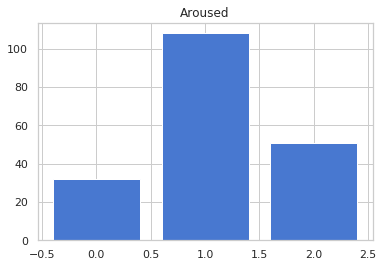

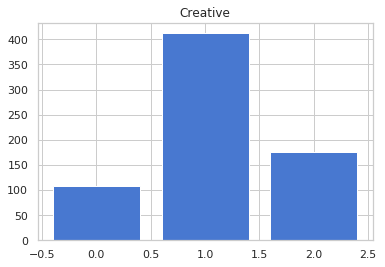

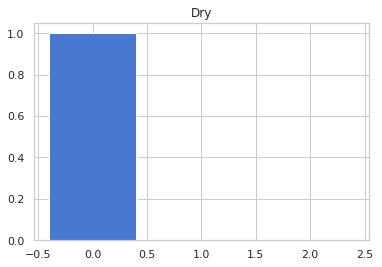

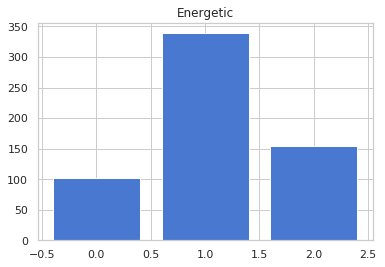

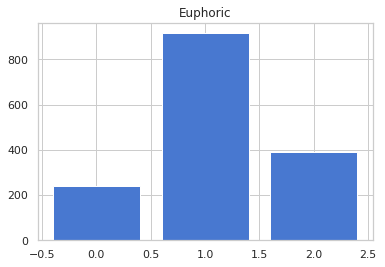

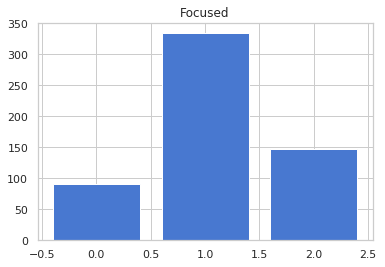

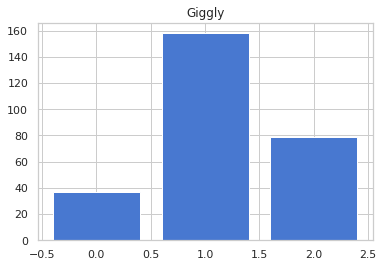

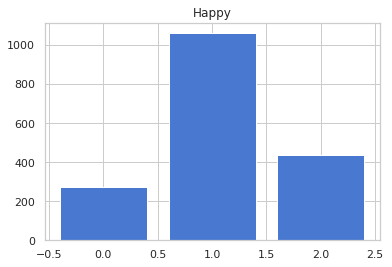

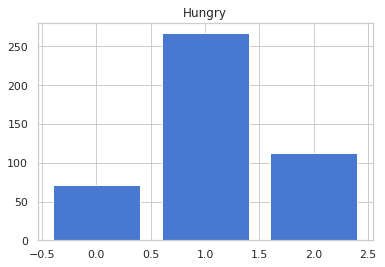

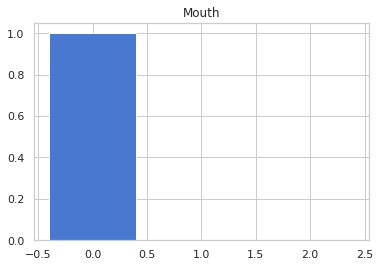

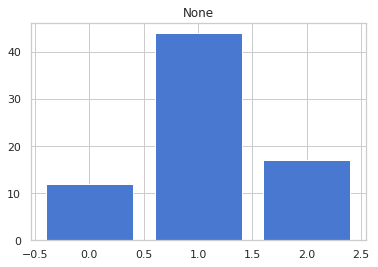

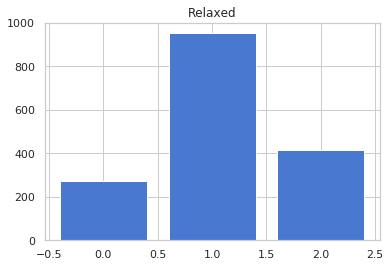

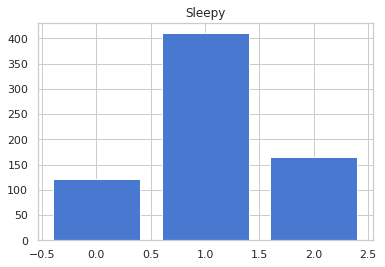

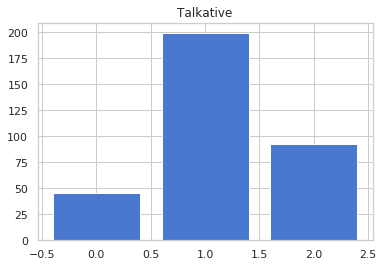

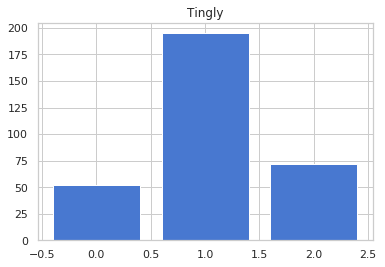

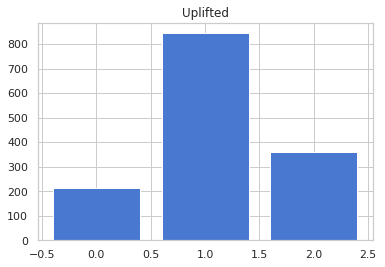

In [0]:
effect_x = effect_df.drop(['Type', 'Rating_bin'], axis=1).columns
effect_df['Rating_bin'].value_counts()
for effect in effect_x:
  effect_sum = []
  effect_sum.append(effect_df[effect_df['Rating_bin'] == 0][effect].sum())
  effect_sum.append(effect_df[effect_df['Rating_bin'] == 1][effect].sum())
  effect_sum.append(effect_df[effect_df['Rating_bin'] == 2][effect].sum())
  plt.bar(x=[0,1,2], height=effect_sum)
  plt.title(effect)
  plt.show()
  print('\n\n')

### Visualize the descriptions

In [0]:
## The most common words in the descriptions based on the different rating bins
pip install wordcloud

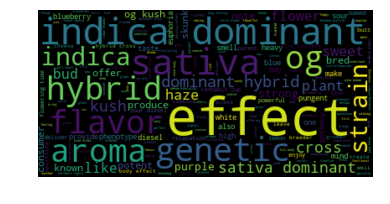

In [0]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline


## Combine all words in the original descriptions to one long string then apply the wordcloud on it
stop_words = stopwords.words('english') + ['strain', 'genetic']
text = [SnowballStemmer(language='english').stem(w) for w in df1['Description']]
text = " ".join(word for word in text)
wordcloud = WordCloud(stopwords=stop_words).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

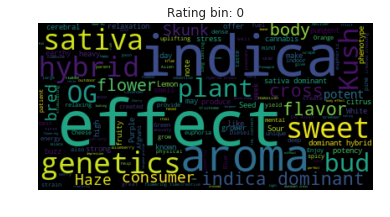

In [0]:
# Now looking into the word clouds that are for each rating category
bin_0_review_text = [SnowballStemmer(language='english').stem(w) for w in df1['Description']]
bin_0_review_text = " ".join(description for description in df1.loc[df1['Rating_bin']==0]['Description'])
wordcloud = WordCloud(stopwords=stop_words).generate(bin_0_review_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Rating bin: 0')
plt.axis('off')
plt.show()

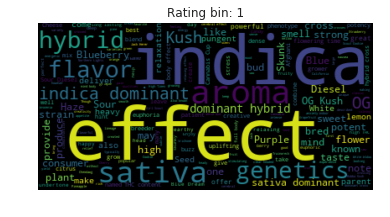

In [0]:
# Now looking into the word clouds that are for each rating category
bin_1_review_text = [SnowballStemmer(language='english').stem(w) for w in df1['Description']]
bin_1_review_text = " ".join(description for description in df1.loc[df1['Rating_bin']==1]['Description'])
wordcloud = WordCloud(stopwords=stop_words).generate(bin_1_review_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Rating bin: 1')
plt.axis('off')
plt.show()

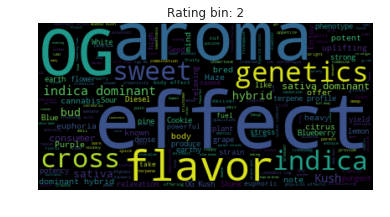

In [0]:
# Now looking into the word clouds that are for each rating category
bin_2_review_text = [SnowballStemmer(language='english').stem(w) for w in df1['Description']]
bin_2_review_text = " ".join(description for description in df1.loc[df1['Rating_bin']==2]['Description'])
wordcloud = WordCloud(stopwords=stop_words).generate(bin_2_review_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Rating bin: 2')
plt.axis('off')
plt.show()

### Visualizing the dataset

<H3>
    The following section shows one method of preprocessing the text using scikit-learn's Count Vectorizer and TF-IDF. This is a bag of words model that will count instances of words in the text, and then compute the term frequency-inverse document frequency to assess the importance of words
</H3>

In [0]:
#imports
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [0]:
#define the cleaning function for scikit learn
def clean_text_skl(text):
    
    #make all words lowercase
    clean_skl = text.lower()
    
    #tokenize and remove special characters
    tokenizer = RegexpTokenizer(r'\w+')
    clean_skl = tokenizer.tokenize(clean_skl)
        
    #lemmatize the text
#     clean_skl = [WordNetLemmatizer().lemmatize(w) for w in clean_skl]
    clean_skl = [SnowballStemmer(language='english').stem(w) for w in clean_skl]
        
    #remove stopwords
    clean_skl = [token for token in clean_skl if not token in stopwords.words('english')]
    clean_skl = ' '.join(clean_skl)
    
    return clean_skl

In [0]:
#clean the description feature
df1['Descr_clean_skl'] = df1['Description'].apply(clean_text_skl)

In [0]:
#instantiate the vectorizer pipeline
vectorizer = CountVectorizer()
tfidf = TfidfTransformer()

pipe = make_pipeline(vectorizer, tfidf)

In [0]:
#transform X
X = pipe.fit_transform(df1['Descr_clean_skl'])

In [0]:
# X = descr_model[descr_model.wv.vocab]
y = df1['Rating']

In [0]:
#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=54, test_size=0.3)

In [0]:
#Lasso
lass = Lasso()

lass.fit(X_train, y_train)

y_pred_lass = lass.predict(X_test)

In [0]:
#Ridge
ridge = Ridge()

ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

In [0]:
#Decision Tree Regressor
dtr = DecisionTreeRegressor()

dtr.fit(X_train, y_train)

y_pred_dtr = dtr.predict(X_test)

In [0]:
#measure models
from sklearn.metrics import mean_squared_error as MSE

lass_rmse = MSE(y_test, y_pred_lass)**(1/2)
ridge_rmse = MSE(y_test, y_pred_ridge)**(1/2)
dtr_rmse = MSE(y_test, y_pred_dtr)**(1/2)

print('For context, the standard deviation of the target variable is: {}'.format(df1['Rating'].std()))
print('The test rmse for the Lasso model is: {}'.format(lass_rmse))
print('The test rmse for the Ridge model is: {}'.format(ridge_rmse))
print('The test rmse for the Decision Tree model is: {}'.format(dtr_rmse))

For context, the standard deviation of the target variable is: 0.8210546578852871
The test rmse for the Lasso model is: 0.7705083918501985
The test rmse for the Ridge model is: 0.758455941738275
The test rmse for the Decision Tree model is: 1.0078293651406305


After we have models, we need to plot learning curves for all of them to see which is the best fit

<H3>
    The models trained on the bag of words model created by CountVectorizer all perform poorly and underfit the data. To get past this, gensim's Word2Vec will be used to create word embeddings rather than a bag of words model. This model will preserve context by using the Word2Vec neural network to determine the probability of certain words appearing near other words
</H3>

First, the data will need to be preprocessed

In [0]:
#define the cleaning function for gensim
def clean_text(text):
    
    #make all words lowercase
    clean = text.lower()
    
    #tokenize and remove special characters
    tokenizer = RegexpTokenizer(r'\w+')
    clean = tokenizer.tokenize(clean)
        
    #lemmatize the text
#     clean_skl = [WordNetLemmatizer().lemmatize(w) for w in clean]
    clean = [SnowballStemmer(language='english').stem(w) for w in clean]
        
    #remove stopwords
    clean = [token for token in clean if not token in stopwords.words('english')]
    
    return clean

In [0]:
#clean the description feature
df1['Descr_clean'] = df1['Description'].apply(clean_text)

In [0]:
#create the word2vec model
w2v_mod = gensim.models.Word2Vec(df1['Descr_clean'].to_list())

In [0]:
df1.shape

(2277, 9)

In [0]:
#define X and y
X_g = w2v_mod[w2v_mod.wv.vocab]
y_g = df1['Rating_bin']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [0]:
print(len(X_g), len(y_g))

2299 2277


In [0]:
#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_g, y_g, random_state=54, test_size=0.3)

ValueError: ignored

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2277 entries, 0 to 2350
Data columns (total 9 columns):
Strain             2277 non-null object
Type               2277 non-null object
Rating             2277 non-null float64
Effects            2277 non-null object
Flavor             2277 non-null object
Description        2277 non-null object
Rating_bin         2277 non-null int64
Descr_clean_skl    2277 non-null object
Descr_clean        2277 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 257.9+ KB
